In [261]:
import os
import numpy as np
from tqdm import tqdm
import copy

import torch 
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import seaborn as sns

In [243]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# device = torch.device('cpu')

In [244]:
# !wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip
# !unzip -q EuroSAT.zip -d 'EuroSAT/'
# !rm EuroSAT.zip

In [245]:
class EuroSAT(data.Dataset):

    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform 

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        if self.transform:
            x = self.transform(self.dataset[idx][0])
        else: 
            x = self.dataset[idx][0]
        y = self.dataset[idx][1]
        return x, y    

In [246]:
input_size = 224
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

val_transforms = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transforms = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [247]:
ds = datasets.ImageFolder('EuroSAT/2750/')

In [248]:
class_names = ds.classes

print(ds.classes)
print(f"nr classes: {len(ds.classes)}")

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
nr classes: 10


In [249]:
train_data = EuroSAT(ds, train_transforms)
val_data = EuroSAT(ds, val_transforms)
test_data = EuroSAT(ds, test_transforms)

In [250]:
train_ratio = 0.7
val_ratio = 0.15
indices = torch.randperm(len(ds)).tolist()
train_split = int(len(ds) * train_ratio)
val_split = int(len(ds) * val_ratio)

train_data = torch.utils.data.Subset(train_data, indices[:train_split])
val_data = torch.utils.data.Subset(val_data, indices[train_split:train_split+val_split])
test_data = torch.utils.data.Subset(test_data, indices[train_split+val_split:])
print(f"train: {len(train_data)}, val: {len(val_data)}, test: {len(test_data)}")    

train: 18900, val: 4050, test: 4050


In [251]:
workers = 0
batch_size = 12  

train_loader = data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=False
)
val_loader = data.DataLoader(
    val_data, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=False
)
test_loader = data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=False
)

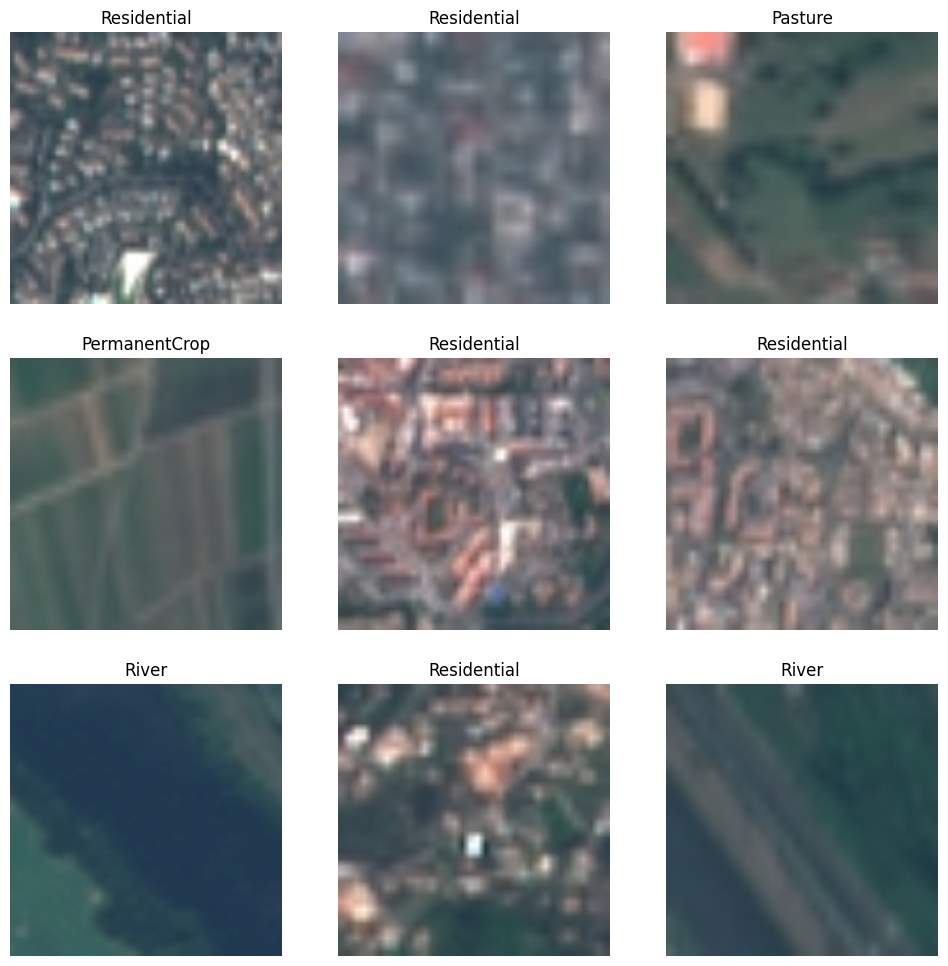

In [252]:
n = 3
inputs, labels = next(iter(train_loader))
fig, axes = plt.subplots(n, n, figsize=(12, 12))
for i in range(n):
    for j in range(n):
        img = inputs[i * n + j].numpy().transpose((1, 2, 0))
        img = np.clip(np.array(imagenet_std) * img + np.array(imagenet_mean), 0, 1)
        axes[i, j].imshow(img)
        title = class_names[labels[i * n + j]]
        axes[i, j].set_title(title)
        axes[i, j].axis('off')
plt.show()

[Text(0, 0, 'AnnualCrop'),
 Text(1, 0, 'Forest'),
 Text(2, 0, 'HerbaceousVegetation'),
 Text(3, 0, 'Highway'),
 Text(4, 0, 'Industrial'),
 Text(5, 0, 'Pasture'),
 Text(6, 0, 'PermanentCrop'),
 Text(7, 0, 'Residential'),
 Text(8, 0, 'River'),
 Text(9, 0, 'SeaLake')]

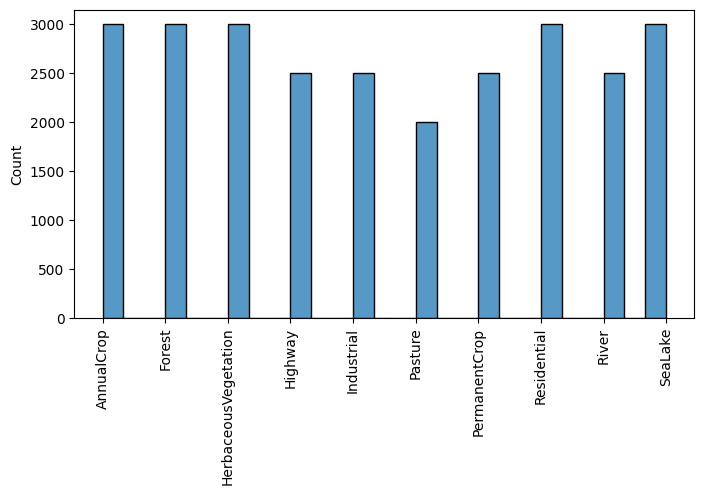

In [253]:
plt.figure(figsize=(8, 4))
hist = sns.histplot(ds.targets)
hist.set_xticks(range(len(ds.classes)))
hist.set_xticklabels(ds.classes, rotation=90)

#### model:

In [254]:
model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features, len(ds.classes))
torchsummary.summary(model, (3, 224, 224))
model = model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

#### training:

In [255]:
epochs = 10
lr = 0.001
optim = torch.optim.SGD(model.parameters(), lr=lr)
crit = torch.nn.CrossEntropyLoss()

In [256]:
def train(model, dataloader, optim, crit):

    model.train()

    running_loss = 0.0
    running_corrects = 0.0

    for i, (inputs, labels) in enumerate(tqdm(dataloader)):
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        optim.zero_grad()

        outputs = model(inputs)

        loss = crit(outputs, labels)
        loss.backward()

        optim.step()

        _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = (running_corrects / len(dataloader.dataset)) * 100
    print(f"train loss: {epoch_loss:.4f}; acc: {epoch_acc:.4f}")

    return epoch_loss, epoch_acc

In [257]:
def eval(model, dataloader, crit, phase='val'):
    
    model.eval()

    running_loss = 0.0
    running_corrects = 0.0

    for i, (inputs, labels) in enumerate(tqdm(dataloader)):

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = crit(outputs, labels)
            _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels)
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = (running_corrects.float() / len(dataloader.dataset)) * 100

    print(f"{phase} loss: {epoch_loss:.4f}; acc: {epoch_acc:.4f}")

    return epoch_loss, epoch_acc

In [258]:
def fit(model, train_loader, val_loader, epochs, lr, crit, optim):

    best_loss = np.inf
    best_model = copy.deepcopy(model.state_dict())

    for e in range(epochs):

        print("Epoch {}".format(e+1))

        train(model, train_loader, optim, crit)
        val_loss, _ = eval(model, val_loader, crit)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model)

    return model

In [259]:
best_model = fit(model, train_loader, val_loader, epochs, lr, crit, optim)

Epoch 1


100%|██████████| 1575/1575 [09:37<00:00,  2.73it/s]


train loss: 1.5393; acc: 54.7037


100%|██████████| 338/338 [00:42<00:00,  7.90it/s]


val loss: 0.8284; acc: 78.7160
Epoch 2


100%|██████████| 1575/1575 [09:36<00:00,  2.73it/s]


train loss: 0.8361; acc: 73.3069


100%|██████████| 338/338 [00:39<00:00,  8.55it/s]


val loss: 0.4266; acc: 88.7407
Epoch 3


100%|██████████| 1575/1575 [09:29<00:00,  2.76it/s]


train loss: 0.6267; acc: 79.5873


100%|██████████| 338/338 [00:40<00:00,  8.29it/s]


val loss: 0.2843; acc: 92.4938
Epoch 4


100%|██████████| 1575/1575 [09:53<00:00,  2.65it/s] 


train loss: 0.5141; acc: 83.2169


100%|██████████| 338/338 [00:40<00:00,  8.37it/s]


val loss: 0.2169; acc: 94.2716
Epoch 5


100%|██████████| 1575/1575 [09:38<00:00,  2.72it/s]


train loss: 0.4508; acc: 85.3333


100%|██████████| 338/338 [00:40<00:00,  8.34it/s]


val loss: 0.1951; acc: 94.6420
Epoch 6


100%|██████████| 1575/1575 [09:48<00:00,  2.68it/s]


train loss: 0.4092; acc: 86.7672


100%|██████████| 338/338 [00:42<00:00,  7.93it/s]


val loss: 0.1440; acc: 96.0494
Epoch 7


100%|██████████| 1575/1575 [09:49<00:00,  2.67it/s]


train loss: 0.3854; acc: 87.1746


100%|██████████| 338/338 [00:43<00:00,  7.73it/s]


val loss: 0.1556; acc: 96.0741
Epoch 8


100%|██████████| 1575/1575 [10:01<00:00,  2.62it/s]


train loss: 0.3663; acc: 87.9894


100%|██████████| 338/338 [00:43<00:00,  7.82it/s]


val loss: 0.1384; acc: 96.3951
Epoch 9


100%|██████████| 1575/1575 [38:39<00:00,  1.47s/it]    


train loss: 0.3468; acc: 88.9841


100%|██████████| 338/338 [00:40<00:00,  8.26it/s]


val loss: 0.1257; acc: 96.5185
Epoch 10


100%|██████████| 1575/1575 [09:29<00:00,  2.76it/s]


train loss: 0.3281; acc: 89.1799


100%|██████████| 338/338 [00:39<00:00,  8.54it/s]


val loss: 0.1122; acc: 96.7901


#### testing: 

In [260]:
test_loss, _ = eval(best_model, test_loader, crit, phase='test')

100%|██████████| 338/338 [00:43<00:00,  7.68it/s]

test loss: 0.1239; acc: 96.1975


In [262]:
dir = 'models/'
if not os.path.exists(dir):
    os.makedirs(dir)
model_file = os.path.join(dir, 'resnet101_eurosat_best_model.pth')

In [264]:
def save_model(model, model_file):
    torch.save(model.state_dict(), model_file)
    print(f"saved model to {model_file}")

In [265]:
save_model(best_model, model_file)

saved model to models/resnet101_eurosat_best_model.pth


In [266]:
def load_model(model_file):

    model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
    model.fc = torch.nn.Linear(model.fc.in_features, len(ds.classes))
    model.load_state_dict(torch.load(model_file))
    model.eval()

    print(f"model {model_file} loaded")
    
    return model

In [267]:
model = load_model(model_file)

model models/resnet101_eurosat_best_model.pth loaded


results:

Text(0.5, 1.0, 'true: PermanentCrop;\n pred: PermanentCrop')

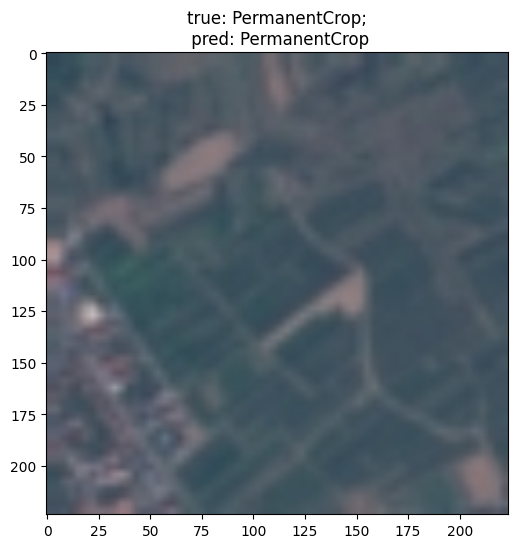

In [272]:
i = 18
img, label = test_data[i]

model = model.to('cpu')
out = model(img.unsqueeze(0))
_, pred = torch.max(out, 1)

label = class_names[label]
pred = class_names[pred[0]]

img = img.cpu().numpy().transpose((1, 2, 0))
img = np.clip(np.array(imagenet_std) * img + np.array(imagenet_mean), 0, 1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img)
ax.set_title(f"true: {label};\n pred: {pred}")

#### torchgeo library:

In [274]:
import timm 
from torchgeo.models import ResNet50_Weights

/Users/paulemilschmid/miniconda3/envs/geo_py11/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [276]:
weights = ResNet50_Weights.SENTINEL2_RGB_MOCO
model = timm.create_model(
    'resnet50', 
    in_chans=weights.meta['in_chans'],
    num_classes=len(ds.classes)
)
model.load_state_dict(weights.get_state_dict(progress=True), strict=False)

torchsummary.summary(model, (3, 224, 224))
model = model.to(device)

Downloading: "https://hf.co/torchgeo/resnet50_sentinel2_rgb_moco/resolve/efd9723b59a88e9dc1420dc1e96afb25b0630a3c/resnet50_sentinel2_rgb_moco-2b57ba8b.pth" to /Users/paulemilschmid/.cache/torch/hub/checkpoints/resnet50_sentinel2_rgb_moco-2b57ba8b.pth
100.0%


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─Identity: 3-6                [-1, 64, 56, 56]          --
|    |    └─ReLU: 3-7                    [-1, 64, 56, 56]          --
| 

In [277]:
optim = torch.optim.SGD(model.parameters(), lr=lr)
best_model = fit(model, train_loader, val_loader, 5, lr, crit, optim)

Epoch 1


100%|██████████| 1575/1575 [06:01<00:00,  4.35it/s]


train loss: 2.2677; acc: 37.5820


100%|██████████| 338/338 [00:27<00:00, 12.25it/s]


val loss: 2.2000; acc: 49.0123
Epoch 2


100%|██████████| 1575/1575 [05:50<00:00,  4.49it/s]


train loss: 2.1160; acc: 44.4127


100%|██████████| 338/338 [00:24<00:00, 13.65it/s]


val loss: 1.8805; acc: 49.2099
Epoch 3


100%|██████████| 1575/1575 [05:48<00:00,  4.52it/s]


train loss: 1.7954; acc: 46.0476


100%|██████████| 338/338 [00:25<00:00, 13.26it/s]


val loss: 1.4542; acc: 59.9259
Epoch 4


100%|██████████| 1575/1575 [05:50<00:00,  4.50it/s]


train loss: 1.4860; acc: 54.1376


100%|██████████| 338/338 [00:25<00:00, 13.17it/s]


val loss: 1.1367; acc: 68.0494
Epoch 5


100%|██████████| 1575/1575 [05:52<00:00,  4.47it/s]


train loss: 1.2402; acc: 62.9100


100%|██████████| 338/338 [00:24<00:00, 13.54it/s]

val loss: 0.8874; acc: 80.3210
